In [453]:
import sys, os
helper_py_location = os.path.abspath(os.path.join(os.path.join(os.getcwd(), "../..") ,"src","helper"))
print(helper_py_location)
sys.path.append(helper_py_location)

In [454]:
import helper
HF_returns_original = helper.load_data('HW_Hedge_Fund.xlsx',1)
M_ER_country_original = helper.load_data('HW_World.xlsx')
Emp_factors_original = helper.load_data('HW_Factors.xlsx')
HP_DJ_Sto_original = helper.load_data('HW_DJIA_Prices.xlsx',4)

HP_DJ_Sto_Ind_ori = helper.load_data('HW_DJIA_Prices.xlsx')
HP_DJ_Sto_Ind = HP_DJ_Sto_Ind_ori.copy()


#clean
HF_returns =HF_returns_original.copy()
Emp_factors = Emp_factors_original.copy()
M_ER_country = M_ER_country_original.copy()
HP_DJ_Sto = HP_DJ_Sto_original.copy()

Emp_factors.iloc[:, 1:] = Emp_factors.iloc[:, 1:].div(100)
M_ER_country.iloc[:,1:] = M_ER_country.iloc[:,1:].div(100)
Emp_factors.rename(columns={Emp_factors.keys()[0]: 'Date'}, inplace=True)

### Part 3 Portfolio Construction
* famlize the Dow Jones
* famlize diff weighting methodologies

1. Different Portfolios - weights

In [455]:
print(type(HP_DJ_Sto))
HP_DJ_Sto.head()

,Date,MMM,AXP,AMGN,AAPL,BA,CAT,CVX,CSCO,KO,...,NKE,PG,CRM,BAC,UNH,VZ,HWP,PFE,WMT,DJIA
0,2004-06-30,90.01,51.38,54.57,49.0842,51.09,79.44,94.11,23.70,50.48,...,75.75,54.44,16.07,84.62,62.25,36.19,21.10,34.28,52.76,10139.71
1,2004-07-30,82.36,50.25,56.88,52.3474,50.75,73.49,95.65,20.92,43.86,...,72.71,52.15,13.01,85.01,62.90,38.54,20.15,31.96,53.01,10173.92
2,2004-08-31,82.36,50.02,59.29,58.8130,52.22,72.70,97.50,18.76,44.71,...,75.31,55.97,13.00,44.98,66.13,39.25,17.89,32.67,52.67,10080.27
3,2004-09-30,79.97,51.46,56.81,79.5303,51.62,80.45,53.64,18.10,40.05,...,78.80,54.12,15.63,43.33,73.74,39.38,18.75,30.60,53.20,10027.47
4,2004-10-29,77.57,53.07,56.80,101.7654,49.90,80.54,53.06,19.21,40.66,...,81.31,51.18,20.32,44.79,72.40,39.10,18.66,28.95,53.92,10428.02


Build diff weight stragy

In [456]:
import pandas as pd
import numpy as np
Portfolio = []
intern = []
# new_weight = pd.DataFrame()
number_of_stock = HP_DJ_Sto.iloc[0,1:-1].shape[0]
price_only = HP_DJ_Sto.iloc[:,1:-1]
start_Price = HP_DJ_Sto.iloc[0,1:-1]
start_shares = HP_DJ_Sto_Ind_ori.iloc[1,1:-1]
returns = price_only.pct_change()
#value
mkt_Cap =  np.array(start_Price)*np.array(start_shares)
total_Cap = np.sum(mkt_Cap)
for i in range(number_of_stock):
    intern.append(mkt_Cap[i]/total_Cap)
Portfolio.append(intern) 

#equal_weight
intern = [1/number_of_stock for _ in range(number_of_stock)]
Portfolio.append(intern) 

#min_var
cov_matrix = returns.cov()
one = np.ones(cov_matrix.shape[1])
Inv_cov = np.linalg.inv(cov_matrix)

# min_var_weights = Inv_cov.dot(one) / np.dot(one.T, Inv_cov.dot(one))
min_var_weights = np.dot(Inv_cov, one) / \
                  np.dot(one.T, Inv_cov.dot(one))
# print(min_var_portfolio)
Portfolio.append(min_var_weights.tolist())

'''  min_var_weights = Inv_cov@one/np.sum(Inv_cov@one)
Portfolio.append(min_var_weights.tolist())  '''

#naive risk parity
vol = price_only.pct_change().std()*np.sqrt(12)
inverse_vol = 1 / vol
normalized_I_vol = [x / sum(inverse_vol) for x in inverse_vol]
Portfolio.append(normalized_I_vol)

#Tangent --- ost Diversified Portfolio
RF = 0.02
ret_matix = returns.mean()*12 - RF
tangent_weight = np.dot(Inv_cov,ret_matix)/ \
                np.dot(one.T,Inv_cov.dot(ret_matix))
Portfolio.append(tangent_weight)


# display(weight)


In [457]:
# #buy largest
# industries = HP_DJ_Sto_Ind.iloc[0,1:-1]
# # Drop the first row to retain only stock prices
# # mkt_Cap =  np.array(start_Price)*np.array(start_shares)
# # total_Cap = np.sum(mkt_Cap)

# mkt_cap_ind = pd.DataFrame(mkt_Cap, index=HP_DJ_Sto_Ind.columns[1:-1], columns=['mkt_cap'])
# largest_stocks = mkt_cap_ind.groupby(industries, axis=0).idxmax()
# largest_stocks.values
# largest_stocks.shape

In [458]:
#buy largest
industries = HP_DJ_Sto_Ind.iloc[0,1:-1]
# Drop the first row to retain only stock prices
# mkt_Cap =  np.array(start_Price)*np.array(start_shares)
# total_Cap = np.sum(mkt_Cap)

mkt_cap_ind = pd.DataFrame(mkt_Cap, index=HP_DJ_Sto_Ind.columns[1:-1], columns=['mkt_cap'])
largest_stocks = mkt_cap_ind.groupby(industries, axis=0).idxmax()
# largest_stocks = HP_DJ_Sto_Ind.groupby(industries, axis=1).idxmax(axis = 1)
weight_of_buylarge = 1/largest_stocks.shape[0]
largest_stocks_weights=[]

for stock in HP_DJ_Sto_Ind_ori.iloc[:,1:-1].columns:
    if stock in largest_stocks.values:
        largest_stocks_weights.append(weight_of_buylarge)
    else:
            largest_stocks_weights.append(0)
Portfolio.append(largest_stocks_weights)

C:\Users\zhaoj\AppData\Local\Temp\ipykernel_31572\2772243726.py:8: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  largest_stocks = mkt_cap_ind.groupby(industries, axis=0).idxmax()


In [459]:
#idustry_equal
HP_DJ_Sto_Ind = HP_DJ_Sto_Ind_ori.copy()
industries = HP_DJ_Sto_Ind.iloc[0,1:-1]
# HP_DJ_Sto_Ind = HP_DJ_Sto_Ind.iloc[1]

number_ind = HP_DJ_Sto_Ind.groupby(industries, axis=1).count().iloc[0]
equal_weights = number_ind.loc[HP_DJ_Sto_Ind_ori.iloc[0,1:-1]].apply(lambda x:1/x*0.2).values
Portfolio.append(equal_weights)

C:\Users\zhaoj\AppData\Local\Temp\ipykernel_31572\1025226775.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  number_ind = HP_DJ_Sto_Ind.groupby(industries, axis=1).count().iloc[0]


In [460]:
# len(Portfolio[4])
weight = pd.DataFrame(Portfolio,
                      index = ['value','equal_weight','min_var','naive','tangent','large5','idustry_equal'], 
                      columns = HP_DJ_Sto.columns[1:-1])
                    #   ,index = ['value','equal_weight','min_var','naive','tangent','large5','idustry_equal'], columns = HP_DJ_Sto.columns[1:])

weight.T

,value,equal_weight,min_var,naive,tangent,large5,idustry_equal
MMM,0.022431,0.033333,0.082040,0.039922,-0.314359,0.0,0.020000
AXP,0.020921,0.033333,-0.012234,0.024584,-0.041348,0.0,0.050000
AMGN,0.022003,0.033333,-0.009578,0.032634,0.112866,0.0,0.020000
AAPL,0.060244,0.033333,0.087575,0.024223,0.416469,0.0,0.028571
BA,0.013725,0.033333,0.020401,0.024914,0.079200,0.0,0.050000
CAT,0.008654,0.033333,0.006949,0.024308,0.149701,0.0,0.020000
CVX,0.032087,0.033333,0.034633,0.030633,0.134854,0.2,0.050000
CSCO,0.051060,0.033333,-0.039859,0.030877,0.008579,0.0,0.028571
KO,0.039177,0.033333,0.001229,0.039531,-0.108516,0.0,0.020000
DIS,0.016668,0.033333,0.031916,0.032606,0.017418,0.0,0.040000


### 2. Compare Portfolios

In [461]:
# HP_DJ_Sto.loc[:,'Date'] === HP_DJ_Sto['Date']

In [478]:
display(HP_DJ_Sto.iloc[:,-1])

0      10139.71
1      10173.92
2      10080.27
3      10027.47
4      10428.02
         ...   
218    28725.51
219    32732.95
220    34589.77
221    33147.25
222    34086.04
Name: DJIA, Length: 223, dtype: float64

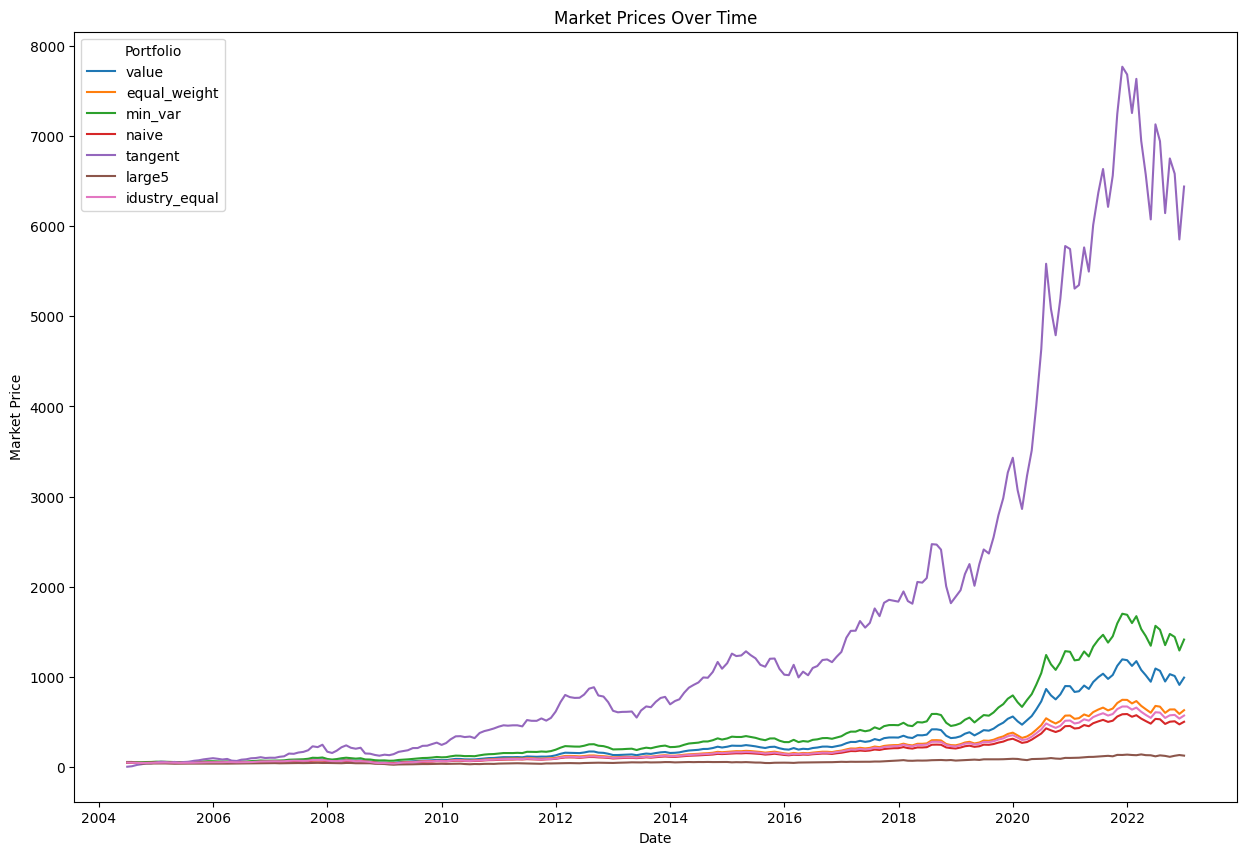

In [462]:
import matplotlib.pyplot as plt
output_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'output')

HP_DJ_Sto.shape # 223x32
weight.shape # 7* 30
market_prices = np.dot(weight,HP_DJ_Sto.iloc[:,1:-1].T)
# pd.DataFrame(market_prices).shape
mkt_P_df = pd.DataFrame(market_prices, index=weight.index, columns=HP_DJ_Sto['Date'])
mkt_P_bench_df = HP_DJ_Sto.iloc[:,-1].T
plt.figure(figsize=(15, 10))
for stock in mkt_P_df.index:
    plt.plot(mkt_P_df.columns, mkt_P_df.loc[stock,:], label=stock)

plt.title('Market Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Market Price')
plt.legend(title='Portfolio')
plt.savefig(os.path.join(output_folder,'Market_Prices_Over_Time.png'))
plt.show()




### 3.Performance Measures

In [464]:
RF = 0.02
HP_DJ_Sto_Ind = HP_DJ_Sto_Ind_ori.copy()
HP_DJ_Sto_Ind = HP_DJ_Sto_Ind[4:]
HP_DJ_Sto_Ind.columns = HP_DJ_Sto_Ind.columns[:-1].tolist() + ['DJIA']
HP_DJ_Sto_Ind.columns =  ['Date'] +  HP_DJ_Sto_Ind.columns[1:].tolist()
Backtesting_Period = HP_DJ_Sto_Ind[HP_DJ_Sto_Ind['Date'] <= pd.to_datetime('2019-01-01')]
Test_period = HP_DJ_Sto_Ind[HP_DJ_Sto_Ind['Date'] > pd.to_datetime('2019-01-01')]



In [465]:
def Month_to_annu_return(price_list:pd.DataFrame):
    list_intern = []
    for i in range(0, price_list.shape[0]-12, 12):
        xx = price_list.iloc[i+11].values/price_list.iloc[i].values - 1
        list_intern.append(xx)
    return list_intern

def calculate_average_annualized_return(price_list: pd.DataFrame):
    """
    Calculate the average annualized return for each stock in the given DataFrame.

    Parameters:
    price_list (pd.DataFrame): DataFrame containing the stock prices.

    Returns:
    list: List containing the average annualized return for each stock.
    """
    # annu_return = Month_to_annu_return(price_list)
    # average_annu = np.mean(np.array(annu_return), axis=0).tolist()
    annu_return = np.mean(price_list.pct_change(),axis=0)*12
    average_annu = annu_return.tolist()
    # average_annu = annu_return.to_frame()
    return average_annu

def volatility(sto_price: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the volatility of the returns for each stock in the given DataFrame.

    Parameters:
    sto_price (pd.DataFrame): DataFrame containing the stock prices.

    Returns:
    pd.DataFrame: DataFrame containing the volatility of the returns for each stock.
    """
    # Calculate the daily returns
    daily_returns = sto_price.pct_change()
    
    # Calculate the volatility (standard deviation of daily returns)
    volatility = daily_returns.std() * np.sqrt(12)  # Assuming 252 trading days in a year
    
    return volatility

def skewness(sto_price: pd.DataFrame):
    daily_returns = sto_price.pct_change()
    skewness_values = daily_returns.skew()
    return skewness_values


def max_drawdown(sto_price: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the maximum drawdown for each stock in the given DataFrame.

    Parameters:
    sto_price (pd.DataFrame): DataFrame containing the stock prices.

    Returns:
    pd.DataFrame: DataFrame containing the maximum drawdown for each stock.
    """
    # Calculate the cumulative returns
    cumulative_returns = (sto_price.pct_change() + 1).cumprod()
    
    # Calculate the peak
    peak = cumulative_returns.expanding(min_periods=1).max()

    # Calculate the drawdown
    drawdown = (cumulative_returns - peak) / peak
    
    # Calculate the maximum drawdown
    max_drawdown = drawdown.min()
    
    max_drawdown = max_drawdown.abs()
    return max_drawdown

def sharpe_ratio(sto_price: pd.DataFrame, RF :float):
    """
    Calculate the Sharpe Ratio for each stock in the given DataFrame.

    Parameters:
    sto_price (pd.DataFrame): DataFrame containing the monthly prices of each stock.
    RF (float): Risk-free rate.

    Returns:
    pd.DataFrame: DataFrame containing the Sharpe Ratio for each stock.
    """
    # Calculate the monthly returns
    monthly_returns = sto_price.pct_change()
    
    # Calculate the average monthly return
    avg_monthly_return = monthly_returns.mean() * 12
    
    # Calculate the standard deviation of monthly returns
    std_dev_monthly_return = monthly_returns.std() * np.sqrt(12)
    
    # Calculate the Sharpe Ratio
    sharpe_ratio = (avg_monthly_return - RF) / std_dev_monthly_return
    
    return sharpe_ratio

def calculate_portfolio_metrics(HP_DJ_Sto_Ind, RF):
    intern_list = []
    HP_DJ_Sto = HP_DJ_Sto_Ind.iloc[:,1:] #Data without date
    Date = HP_DJ_Sto_Ind.iloc[:,1] #Only Date

    average_annu = calculate_average_annualized_return(HP_DJ_Sto)
    intern_list.append(average_annu)
    
    volatility_values = volatility(HP_DJ_Sto).values.tolist()
    intern_list.append(volatility_values)
    
    skewness_values = skewness(HP_DJ_Sto).values.tolist()
    intern_list.append(skewness_values)
    
    max_drawdown_values = max_drawdown(HP_DJ_Sto).values.tolist()
    intern_list.append(max_drawdown_values)
    
    sharpe_ratio_values = sharpe_ratio(HP_DJ_Sto,RF).values.tolist()
    intern_list.append(sharpe_ratio_values)
    
    return intern_list

In [466]:
Risk_free = 0.02
BT_performance = calculate_portfolio_metrics(Backtesting_Period,Risk_free)
BT_perform_df = pd.DataFrame(BT_performance,
                  index = ['Annu_return', 'Volatility','Skewness','Maximum drawdown','Sharpe Ratio'],
                   columns=HP_DJ_Sto_Ind.columns[1:])


C:\Users\zhaoj\AppData\Local\Temp\ipykernel_31572\4246926023.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annu_return = np.mean(price_list.pct_change(),axis=0)*12
C:\Users\zhaoj\AppData\Local\Temp\ipykernel_31572\4246926023.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  daily_returns = sto_price.pct_change()
C:\Users\zhaoj\AppData\Local\Temp\ipykernel_31572\4246926023.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) inste

In [467]:
# Filter the portfolio based on annual return 
first_fliter = BT_perform_df.loc[:, BT_perform_df.loc['Annu_return'] >= BT_perform_df.loc['Annu_return', 'DJIA']]
#Sharpe Ratio
second_fliter = first_fliter.loc[:,first_fliter.loc['Sharpe Ratio'] >= first_fliter.loc['Sharpe Ratio','DJIA']]
#skewness
third_fliter = second_fliter.loc[:,second_fliter.loc['Skewness'] >= second_fliter.loc['Skewness','DJIA']]

display(third_fliter)
display(third_fliter.shape)
# display(first_fliter.sort_values(by='Sharpe Ratio', ascending=False)


,AMGEN INC,APPLE COMPUTER INC,BOEING CO,DISNEY WALT CO,HONEYWELL INTERNATIONAL INC,HOME DEPOT INC,MCDONALDS CORP,MICROSOFT CORP,DJIA
Annu_return,0.116621,0.364020,0.159160,0.122530,0.111631,0.132184,0.144342,0.113410,0.071071
Volatility,0.244815,0.336733,0.249561,0.207491,0.211285,0.211880,0.150045,0.228023,0.131181
Skewness,0.946458,-0.226276,-0.380290,-0.202066,-0.671818,-0.176363,-0.065711,0.180836,-0.687844
Maximum drawdown,0.483751,0.569114,0.700543,0.526806,0.564236,0.519880,0.161125,0.561261,0.492970
Sharpe Ratio,0.394671,1.021641,0.557618,0.494142,0.433686,0.529470,0.828697,0.409650,0.389320


(5, 9)

In [468]:
Aggressive_Strategy = third_fliter.loc[:, third_fliter.loc['Annu_return'].idxmax()]
# Invest the cretia which annulized/maximum drawdown biggest
Conservative_Strategy = third_fliter.loc[:,third_fliter.loc['Maximum drawdown'].idxmin()]
display(Conservative_Strategy)

Annu_return         0.144342
Volatility          0.150045
Skewness           -0.065711
Maximum drawdown    0.161125
Sharpe Ratio        0.828697
Name: MCDONALDS CORP, dtype: float64

In [469]:
Conservative_Strategy.index
Conservative_Strategy.name
# third_fliter.columns


'MCDONALDS CORP'

In [470]:
# Risk_free = 0.02
# Aggre_stock = Aggressive_Strategy.name
# Conser_stock = Conservative_Strategy.name
# Test_period.loc[:, ['Date',Aggre_stock, Conser_stock]]

#### Test our strategy

In [471]:
Risk_free =0.02
Aggre_stock = Aggressive_Strategy.name #APPLE COMPUTER INC
Conser_stock = Conservative_Strategy.name #MCDONALDS CORP
Test_perform = calculate_portfolio_metrics(Test_period.loc[:, ['Date',Aggre_stock, Conser_stock,'DJIA']],Risk_free)

test_perform_df = pd.DataFrame(Test_perform,
                  index = ['Annu_return', 'Volatility','Skewness','Maximum drawdown','Sharpe Ratio'],
                   columns=[Aggre_stock,Conser_stock,'DJIA'])
display(test_perform_df)
# display(Test_perform)
# .loc[:,Aggre_stock,Conser_stock]


C:\Users\zhaoj\AppData\Local\Temp\ipykernel_31572\4246926023.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annu_return = np.mean(price_list.pct_change(),axis=0)*12
C:\Users\zhaoj\AppData\Local\Temp\ipykernel_31572\4246926023.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  daily_returns = sto_price.pct_change()
C:\Users\zhaoj\AppData\Local\Temp\ipykernel_31572\4246926023.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) inste

,APPLE COMPUTER INC,MCDONALDS CORP,DJIA
Annu_return,0.370834,0.119391,0.088493
Volatility,0.322972,0.203003,0.193495
Skewness,-0.134556,0.237862,-0.093070
Maximum drawdown,0.264042,0.241409,0.232013
Sharpe Ratio,1.086267,0.489603,0.353980


In [472]:

def save_data_to_pickle(data, pickle_name):
    import pickle,os

    pickle_name = pickle_name+'.pickle'
    output_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'output')
    print(output_folder)
    # if not os.path.exists(output_folder):
    #     os.makedirs(output_folder)
    
    with open(os.path.join(output_folder, pickle_name),'wb') as file:
        pickle.dump(data,file)

save_data_to_pickle(weight, 'Part3_diff_strategy')
save_data_to_pickle(BT_perform_df, 'Part3_BT_performance')
save_data_to_pickle(third_fliter, 'Part3_fliter')
save_data_to_pickle(test_perform_df, 'Part3_test_performance')